In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import json
import nnunetv2
import torch
import numpy as np

from typing import Tuple, Union, List

from pprint import pprint
from nnunetv2.training.dataloading.data_loader_2d import nnUNetDataLoader2D
from nnunetv2.training.dataloading.data_loader_3d import nnUNetDataLoader3D
from nnunetv2.training.dataloading.nnunet_dataset import nnUNetDataset
from nnunetv2.training.nnUNetTrainer.CustomNNUNetTrainer import CustomNNUNetTrainer

from batchgeneratorsv2.helpers.scalar_type import RandomScalar, sample_scalar
from batchgeneratorsv2.transforms.base.basic_transform import ImageOnlyTransform

In [2]:
!ls /data/dkermany_data/OCT/nnUNet_preprocessed/Dataset004_OCTAVEv4

dataset_fingerprint.json  nnUNetPlans_2d	  nnUNetPlans.json
dataset.json		  nnUNetPlans_3d_fullres  splits_final.json
gt_segmentations	  nnUNetPlans_3d_lowres


In [3]:
rgb_colors = np.array([
    [0, 0, 0], # background
    [241, 214, 145],
    [177, 122, 101],
    [111, 184, 210],
    [216, 101, 79],
    [221, 130, 101],
    [144, 238, 144],
    [162, 0, 255],
    [143, 143, 112],
    [224, 240, 252],
    [117, 250, 252],
    [176, 252, 209],
    [252, 252, 84],
    [56, 125, 247],
    [100, 50, 0],
]) / 255.0  # Normalize to [0, 1]
# Create the ListedColormap


In [23]:
%%bash
echo "([
    [0, 0, 0], # background
    [241, 214, 145],
    [177, 122, 101],
    [111, 184, 210],
    [216, 101, 79],
    [221, 130, 101],
    [144, 238, 144],
    [162, 0, 255],
    [143, 143, 112],
    [224, 240, 252],
    [117, 250, 252],
    [176, 252, 209],
    [252, 252, 84],
    [56, 125, 247],
    [100, 50, 0],
]) / 255.0" > colors.py


In [4]:
dataset_folder = "/data/dkermany_data/OCT/nnUNet_preprocessed/Dataset004_OCTAVEv4"

plans_file = f"{dataset_folder}/nnUNetPlans.json"
dataset_json_file = f"{dataset_folder}/dataset.json"
case_identifiers = None # to load all cases

with open(plans_file, "r") as f:
    plans = json.load(f)

with open(dataset_json_file, "r") as f:
    dataset_json = json.load(f)

config_2d = plans["configurations"]["2d"]
batch_size_2d = config_2d["batch_size"]
patch_size_2d = config_2d["patch_size"]

print(f"Batch size: {batch_size_2d}")
print(f"Patch size: {patch_size_2d}")


Batch size: 4
Patch size: [512, 1024]


In [5]:
# tr_transforms = nnUNetTrainer.get_training_transforms(
#     patch_size,
# )
trainer = CustomNNUNetTrainer(plans=plans, configuration="2d", fold=0, dataset_json=dataset_json)

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################



/home/dkermany/octvision3d/nnUNet/nnunetv2/training/nnUNetTrainer/nnUNetTrainer.py:164: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.grad_scaler = GradScaler() if self.device.type == 'cuda' else None


In [6]:
deep_supervision_scales = trainer._get_deep_supervision_scales()

(
  rotation_for_DA,
  do_dummy_2d_data_aug,
  initial_patch_size,
  mirror_axes,
) = trainer.configure_rotation_dummyDA_mirroring_and_inital_patch_size()

print(deep_supervision_scales)
print(rotation_for_DA)
print(initial_patch_size)
print(mirror_axes)
print(trainer.configuration_manager.patch_size)
print(trainer.label_manager)

2024-12-06 15:32:47.566313: do_dummy_2d_data_aug: False
[[1.0, 1.0], [0.5, 1.0], [0.25, 0.5], [0.125, 0.25], [0.0625, 0.125], [0.03125, 0.0625], [0.015625, 0.03125], [0.0078125, 0.015625]]
(-0.2617993877991494, 0.2617993877991494)
[ 893 1204]
(0, 1)
[512, 1024]


In [7]:
tr_transforms = trainer.get_training_transforms(
    patch_size_2d, rotation_for_DA, deep_supervision_scales, mirror_axes, do_dummy_2d_data_aug,
    use_mask_for_norm=trainer.configuration_manager.use_mask_for_norm,
    is_cascaded=trainer.is_cascaded, foreground_labels=trainer.label_manager.foreground_labels,
    regions=trainer.label_manager.foreground_regions if trainer.label_manager.has_regions else None,
    ignore_label=trainer.label_manager.ignore_label
)
pprint(tr_transforms)

ComposeTransforms( transforms = [SpatialTransform( patch_size = [512, 1024], patch_center_dist_from_border = [0, 0], random_crop = False, p_elastic_deform = 0, elastic_deform_scale = (0, 0.2), elastic_deform_magnitude = (0, 0.2), p_rotation = 0.2, rotation = (-0.2617993877991494, 0.2617993877991494), p_scaling = 0.2, scaling = (0.9, 1.1), p_synchronize_scaling_across_axes = 1, p_synchronize_def_scale_across_axes = 0, bg_style_seg_sampling = False, mode_seg = 'bilinear' ), RandomTransform(p=0.2, transform=GaussianNoiseTransform( noise_variance = (0.1, 0.8), p_per_channel = 1, synchronize_channels = True )), RandomTransform(p=0.2, transform=GaussianBlurTransform( blur_sigma = (0.5, 1.0), benchmark = True, synchronize_channels = False, synchronize_axes = False, p_per_channel = 0.5, benchmark_use_fft = {}, benchmark_num_runs = 9 )), RandomTransform(p=0.15, transform=MultiplicativeBrightnessTransform( multiplier_range = BGContrast(contrast_range=(0.75, 1.25)), synchronize_channels = False, 

In [8]:
# From nnUNetTrainer.py line 620
# dataset_tr = nnUNetDataset(
#     dataset_folder,
#     case_identifiers,
#     num_images_properties_loading_threshold=0
# )
dataset_tr, dataset_val = trainer.get_tr_and_val_datasets()

# training pipeline
tr_transforms = trainer.get_training_transforms(
    patch_size_2d, rotation_for_DA, deep_supervision_scales, mirror_axes, do_dummy_2d_data_aug,
    use_mask_for_norm=trainer.configuration_manager.use_mask_for_norm,
    is_cascaded=trainer.is_cascaded, foreground_labels=trainer.label_manager.foreground_labels,
    regions=trainer.label_manager.foreground_regions if trainer.label_manager.has_regions else None,
    ignore_label=trainer.label_manager.ignore_label
)

dataloader_2d = nnUNetDataLoader2D(
    dataset_tr, batch_size_2d,
    initial_patch_size,
    trainer.configuration_manager.patch_size,
    trainer.label_manager,
    oversample_foreground_percent=trainer.oversample_foreground_percent,
    sampling_probabilities=None, pad_sides=None, transforms=tr_transforms
)


2024-12-06 15:32:47.580057: Using splits from existing split file: /data/dkermany_data/OCT/nnUNet_preprocessed/Dataset004_OCTAVEv4/splits_final.json
2024-12-06 15:32:47.580422: The split file contains 5 splits.
2024-12-06 15:32:47.580462: Desired fold for training: 0
2024-12-06 15:32:47.580493: This split has 158 training and 40 validation cases.


In [9]:
def reshape_to_vertical(image, target_height, target_width, mode="bilinear"):
    """
    Reshape a horizontal image to a vertical image by resizing.
    
    Parameters:
        image (torch.Tensor): Input image tensor of shape (H, W).
        target_height (int): Desired height of the reshaped image.
        target_width (int): Desired width of the reshaped image.
        
    Returns:
        torch.Tensor: Resized image tensor of shape (target_height, target_width).
    """
    if len(image.shape) != 2:
        raise ValueError("Input image must be a 2D tensor of shape (H, W).")
    
    # Reshape using bilinear interpolation
    reshaped_image = torch.nn.functional.interpolate(
        image.unsqueeze(0).unsqueeze(0),  # Add batch and channel dimensions
        size=(target_height, target_width),  # Target size
        mode=mode,
        align_corners=False
    )
    return reshaped_image.squeeze(0).squeeze(0)  # Remove batch and channel dimensions

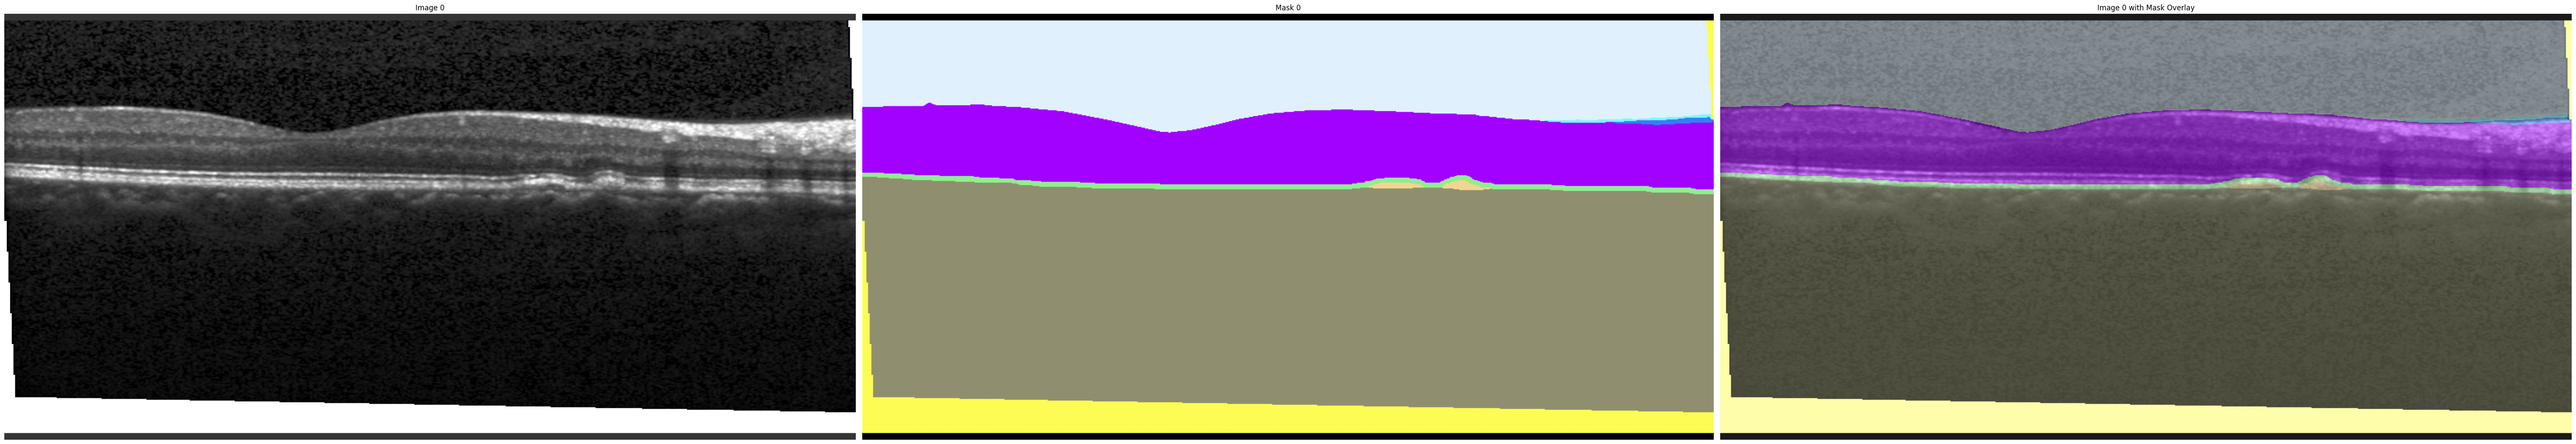

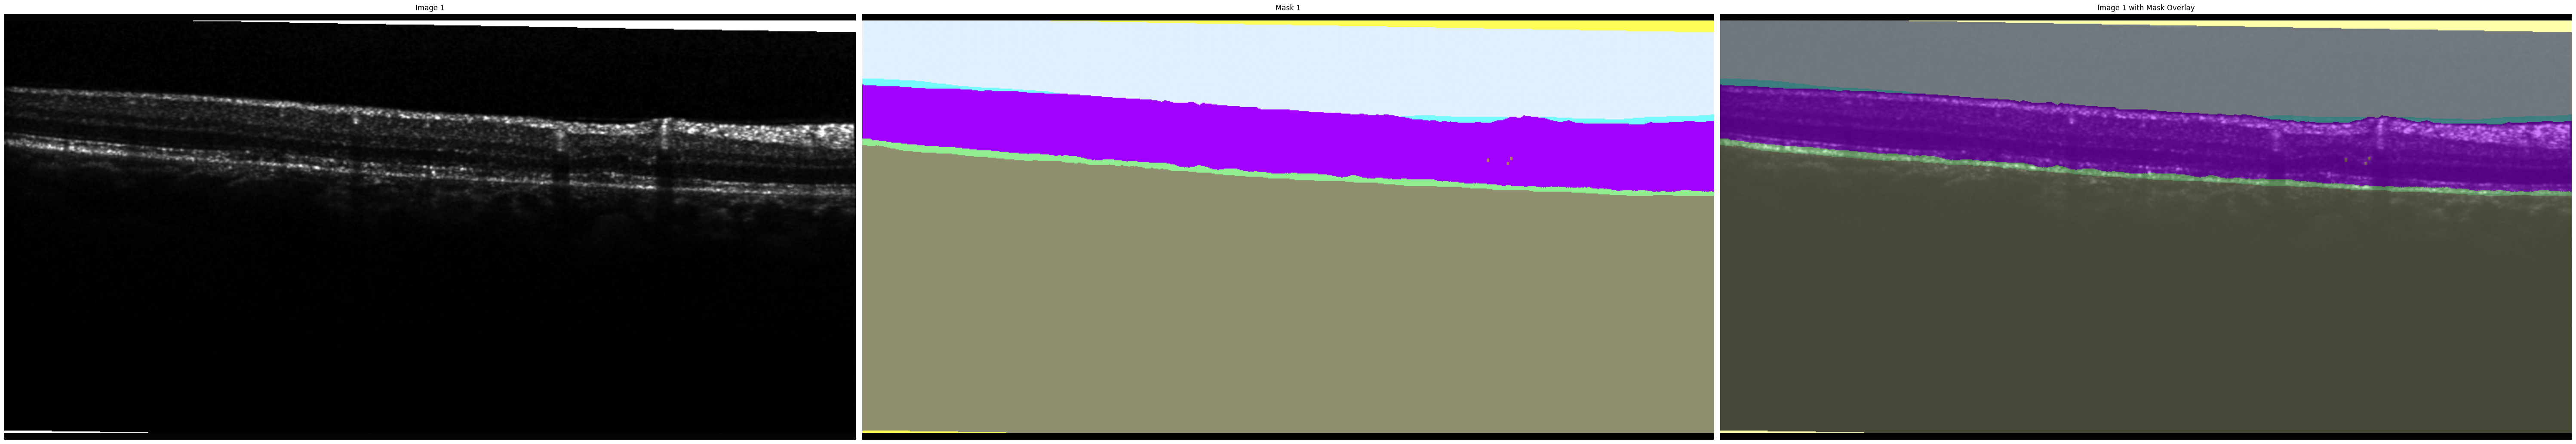

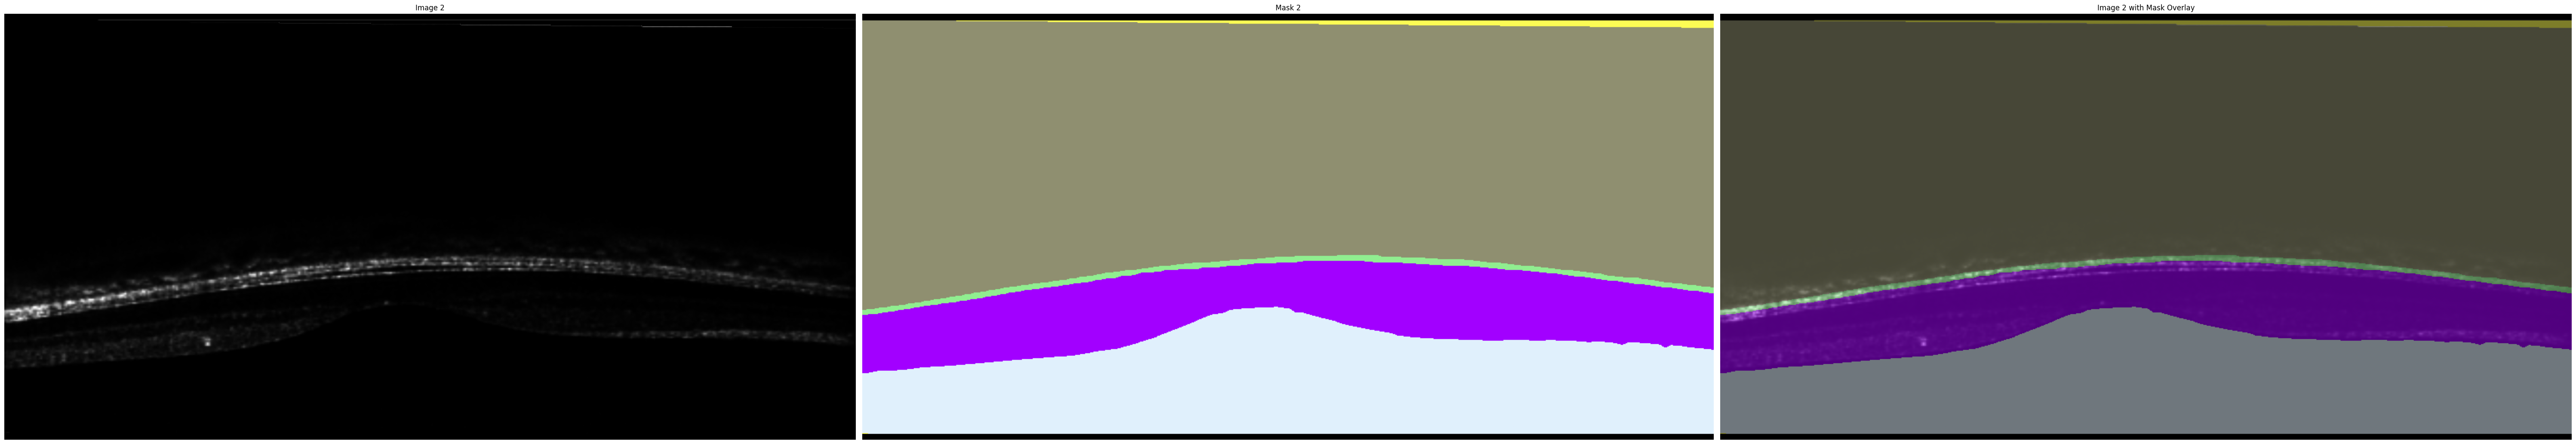

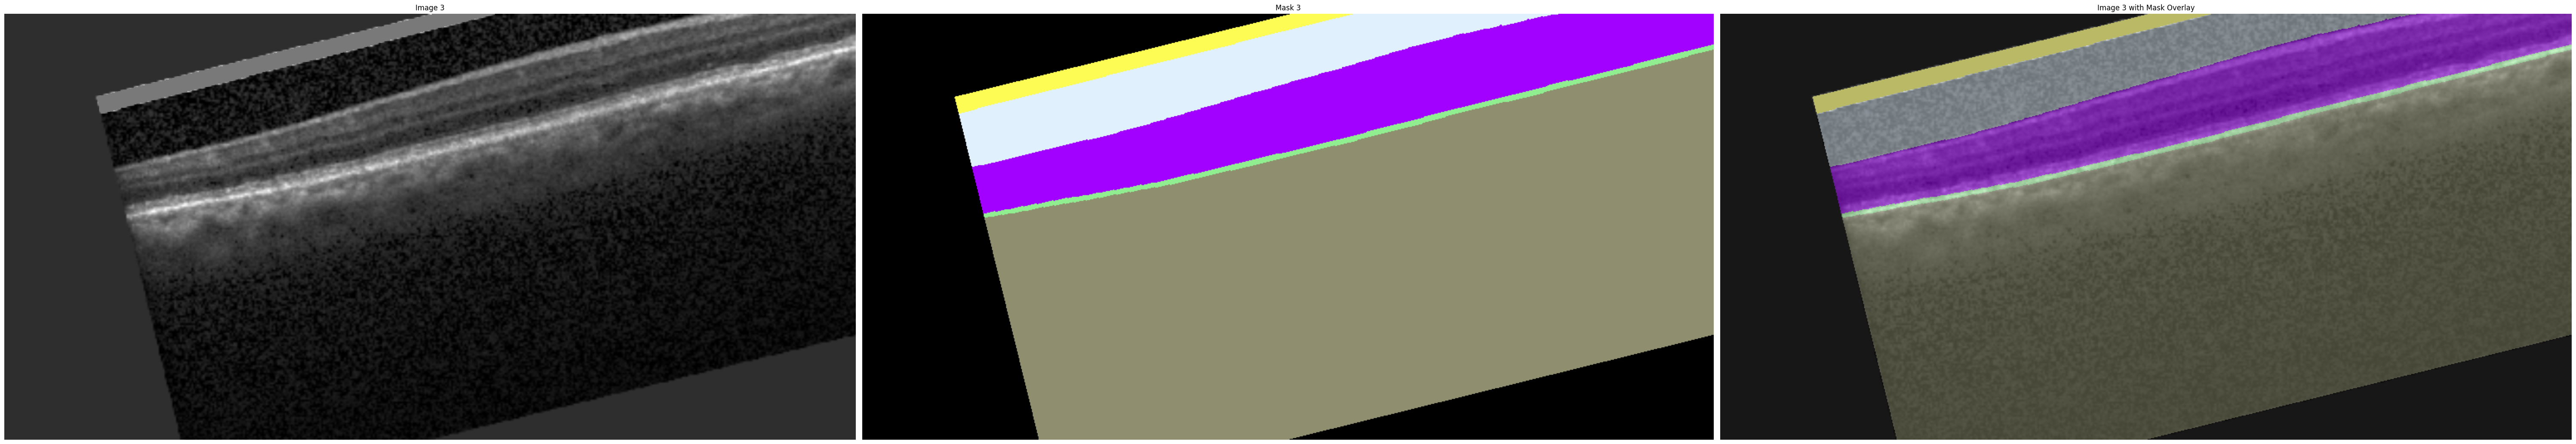

In [16]:
for batch in dataloader_2d:
    data = batch["data"]
    target = batch["target"]

    data_np = data.cpu().numpy().squeeze(1)
    target_np = target[0].cpu().numpy().squeeze(1)

    # Initialize an array to hold the RGB masks
    mask_rgb = np.zeros((target_np.shape[0], target_np.shape[1], target_np.shape[2], 3), dtype=np.float32)  # Shape: [4, 512, 1024, 3]
    
    # Map each class label to its corresponding RGB color
    for i in range(target_np.shape[0]):  # Iterate over batch
        mask = target_np[i].astype(np.int32)  # Ensure integer type
        mask_rgb[i] = rgb_colors[mask]  # Replace class labels with colors

    # Loop over each image in the batch
    for i in range(4):
        fig, axes = plt.subplots(1, 3, figsize=(60, 25))
        
        # Original image
        img = data_np[i]
        # print("unique", np.min(img), np.max(img))
        axes[0].imshow(img, cmap='gray')
        axes[0].set_title(f'Image {i}')
        axes[0].axis('off')
        
        # Corresponding mask
        mask = mask_rgb[i]
        # print(img.shape)
        axes[1].imshow(mask)
        axes[1].set_title(f'Mask {i}')
        axes[1].axis('off')
        
        # Overlayed image and mask
        axes[2].imshow(img, cmap='gray')
        # Create a color overlay where mask is not zero
        overlay = np.ma.masked_where(mask == 0, mask)
        axes[2].imshow(overlay, alpha=0.5)
        axes[2].set_title(f'Image {i} with Mask Overlay')
        axes[2].axis('off')
        
        # axes[1].imshow(random_window_level(img, window=10, level=-4), cmap='gray')
# 
        # axes[2].imshow(random_window_level(img, window=10, level=0), cmap='gray')
# 
       # imgT = torch.Tensor(img)
       # maskT = torch.Tensor(target_np[i])
       # axes[3].imshow(reshape_to_vertical(imgT, imgT.shape[0], imgT.shape[1]//3).numpy(), cmap='gray')
#
       # mask_torch = reshape_to_vertical(maskT, maskT.shape[0], maskT.shape[1]//3).numpy()
       # # Initialize an array to hold the RGB masks
       # mask_color = np.zeros((mask_torch.shape[0], mask_torch.shape[1], 3), dtype=np.float32)  # Shape: [512, 1024, 3]
       # 
       # # Map each class label to its corresponding RGB color
       # mask_slice = mask_torch.astype(np.int32)  # Ensure integer type
       # mask_color = rgb_colors[mask_slice]  # Replace class labels with colors
#
       # print(mask_color.shape)
       # axes[4].imshow(mask_color)

        %matplotlib inline
        plt.tight_layout()
        plt.show()
    
    break

/home/dkermany/octvision3d/nnUNet/nnunetv2/inference/custom_predict_from_raw_data.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(join(model_tra

There are 25 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 25 cases that I would like to predict
(19, 640, 385)


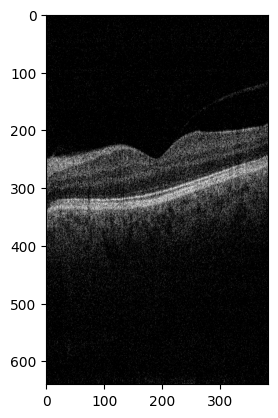

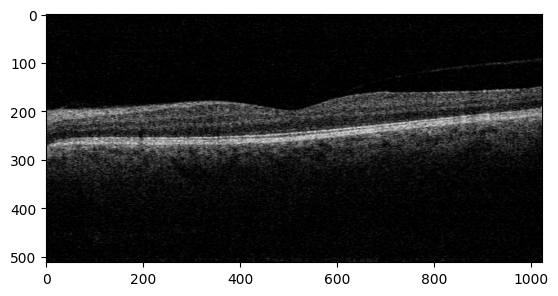

In [11]:
from nnunetv2.inference.custom_predict_from_raw_data import nnUNetPredictor
import torch

cavria_folder = "/data/dkermany_data/OCT/nnUNet_raw/CAVRI-A_nnUNet_Dataset/imagesTs/"
model_folder = "/data/dkermany_data/OCT/nnUNet_results/Dataset004_OCTAVEv4/nnUNetTrainer__nnUNetPlans__2d/"

predictor = nnUNetPredictor(
    tile_step_size=0.5,
    use_gaussian=True,
    use_mirroring=True,
    perform_everything_on_device=True,
    device=torch.device("cuda"),
    verbose=False,
    allow_tqdm=True,
    verbose_preprocessing=False,)
predictor.initialize_from_trained_model_folder(model_folder, (0,1,2,3,4), "checkpoint_best.pth")
iterator = predictor.get_iterator(cavria_folder, cavria_folder)

for batch in iterator:
    data = batch["data"]
    img = data.cpu().numpy().squeeze(0)
    print(img.shape)
    plt.figure()
    plt.imshow(img[9], cmap="gray")

    plt.figure()
    plt.imshow(reshape_to_vertical(torch.Tensor(img[9]), 512, 1024).numpy(), cmap="gray")
    break